In [1]:
# Describe the data
samples = ['Illumina', 'Fasta short reads', 'Fasta long reads']
input_illumina = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Illumina_simulated/Illumina_names_fixed.csv'
input_fasta_short = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Fasta_short_reads/Fasta_short_reads_fixed.csv'
input_fasta_long = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Fasta_long_reads/Fasta_long_reads_fixed.csv'
taxonomy_key = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/01_Collect_sequences/02_Sequences/Downloaded_5dec/Taxonomy_species_genus_corrected.csv'
convertion_table = '/Users/claranordquist/Documents/Universitetet/HT24/Tillämpad_bioinformatik/Applied-bioinformatics/05_Plot_the_results/01_Data/Species_convertion.txt'

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Read the data
illumina = pd.read_csv(input_illumina, index_col='index')
fasta_short = pd.read_csv(input_fasta_short, index_col='Feature ID')
fasta_long = pd.read_csv(input_fasta_long, index_col='Feature ID')
taxonomy = pd.read_csv(taxonomy_key, index_col='Feature ID')
convertion = pd.read_csv(convertion_table)

taxonomic_levels = ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus', 'Species']

# Create a convertion dictionary for species with multiple names
convertion.columns = ['Species', 'Synonyms']
convertion_dict = {}
for ID in convertion.index:
    if convertion.loc[ID, 'Species'] not in convertion_dict.keys():
        convertion_dict[convertion.loc[ID, 'Species']] = [convertion.loc[ID, 'Synonyms']]
    else:
        convertion_dict[convertion.loc[ID, 'Species']].append(convertion.loc[ID, 'Synonyms'])

In [4]:
# Find misclassified sequences
def find_misclassified(dataframe, correct_classification, convertion_table):
    # Create a copy to not mess with the original datafiles
    dataframe_genus_species = dataframe.applymap(lambda x: x.strip() if type(x)==str else x)
    taxonomy_genus_species = correct_classification.applymap(lambda x: x.strip() if type(x)==str else x)
    # dataframe_genus_species = dataframe.copy(deep=True)[['Genus', 'Species']]
    # taxonomy_genus_species = correct_classification.copy(deep=True)[['Genus', 'Species']]
    # taxonomy_genus_species['Genus'] = taxonomy_genus_species['Genus'].str.strip()
    # taxonomy_genus_species['Species'] = taxonomy_genus_species['Species'].str.strip()

    # Look through all sequences
    for ID in dataframe.index:
        # If the whole species name (genus + species) is the same as the taxonomy, the classification is correct
        # If only the species name is the same, it's maybe incorrect
        if dataframe_genus_species.loc[ID,'Species'] == taxonomy_genus_species.loc[ID,'Species']:
            if dataframe_genus_species.loc[ID,'Genus'] == taxonomy_genus_species.loc[ID,'Genus']:
                correct = 'Species'
            else:
                correct = 'Incorrect'
        
        else:
            for level in reversed(dataframe.columns[:-1]):
                if dataframe_genus_species.loc[ID,level] == taxonomy_genus_species.loc[ID,level]:
                    correct = level
                    break
                else:
                    correct = 'Unassigned'

        # Check if the incorrect classifications is because of redudant names by consulting the convertion table
        if correct == 'Incorrect':
            if not pd.isna(dataframe_genus_species.loc[ID,'Species']):
                name = dataframe_genus_species.loc[ID,'Genus'] + ' ' + dataframe_genus_species.loc[ID,'Species']
                tax = taxonomy_genus_species.loc[ID,'Genus'] + ' ' + taxonomy_genus_species.loc[ID,'Species']

                if name in convertion_table.keys():
                    if tax in convertion_table[name]:
                        correct = 'Species'
        dataframe_genus_species.loc[ID, 'Correct'] = correct

    return dataframe_genus_species

In [5]:
def classification_stats(dataframe):
    correct_sequences = dataframe['Correct'].value_counts()
    return pd.Series.to_frame(correct_sequences).transpose()

In [6]:
illumina_misclassified = find_misclassified(illumina, taxonomy, convertion_dict)
fasta_short_misclassified = find_misclassified(fasta_short, taxonomy, convertion_dict)
fasta_long_misclassified = find_misclassified(fasta_long, taxonomy, convertion_dict)

illumina_stats = classification_stats(illumina_misclassified)
fasta_short_stats = classification_stats(fasta_short_misclassified)
fasta_long_stats = classification_stats(fasta_long_misclassified)
all_stats = pd.concat([illumina_stats, fasta_short_stats, fasta_long_stats])
all_stats.index = samples

all_stats_ratio = all_stats.copy(deep=True)
for sample in range(len(samples)):
    all_stats_ratio.iloc[sample,:] /= all_stats.iloc[sample,:].sum()

print(all_stats_ratio)

                    Kingdom  Unassigned     Genus   Species    Family  \
Illumina           0.666667    0.200000  0.088889  0.044444       NaN   
Fasta short reads  0.644444    0.111111  0.111111  0.111111  0.022222   
Fasta long reads   0.613636    0.136364  0.045455  0.181818       NaN   

                      Class  
Illumina                NaN  
Fasta short reads       NaN  
Fasta long reads   0.022727  


In [7]:
# Decide on the color maps for each taxonomic level, as well as for correct/incorrent classification
# Correct classification = Green
# Incorrect classification = Red
# Different taxonomic levels = Ligher or darker colors

# Number of taxonomic levels
n = len(taxonomic_levels)

# Create the color maps
cmap_correct = plt.cm.get_cmap('Greens', n)

color_levels = {}
for i in range(n):
    color_levels[taxonomic_levels[i]] = cmap_correct(i)

color_levels['Incorrect'] = 'crimson'
color_levels['Unassigned'] = 'lightblue'

/var/folders/8y/zlyjdkl554bfq25qgv0m1v5r0000gn/T/ipykernel_2369/510883640.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])


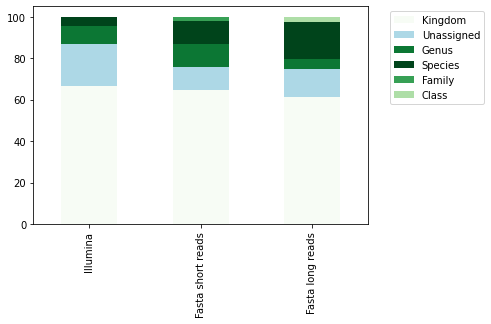

In [8]:
# Plot the number of correct/incorrect classifications for each samples as a stacked barplot
# colors = {'Incorrect': 'crimson', 'Species': 'forestgreen', 'Genus': 'lightgreen'}
fig, ax = plt.subplots()
all_stats_ratio.plot(kind='bar', color=color_levels, stacked=True, ax=ax)
ax.set_yticklabels(['0', '20', '40', '60', '80', '100'])
ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()